# Servenet Pre-Setting


In [1]:
%tensorflow_version 2.x
!nvidia-smi

Wed Aug  5 19:52:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Hyberparameters:
batch_size = 32 #@param {type:"integer"}
# maxLen = 110 #@param {type:"integer"}
# maxNameLen = 10 #@param {type:"integer"}

bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2" #@param ["https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2"]

if bert_path == "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2":
  hiddenSize = 768
elif bert_path == "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/2":
  hiddenSize = 1024

# bert_path = "https://tfhub.dev/tensorflow/albert_en_base/1"  

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import backend as K

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

TF version:  2.3.0
Hub version:  0.8.0


In [4]:
SavePrefix='ServeNet-BERT-ServiceName-DataGenerator-More'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import os

if os.path.isdir("/content/drive/My Drive/ServeNet"):
  os.chdir("/content/drive/My Drive/ServeNet")
else: 
  !git clone https://github.com/yylonly/ServeNet.git
  os.chdir("/content/drive/My Drive/ServeNet")

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [7]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']) # TPU detection
  BUCKET = 'servenet' #@param {type:"string"}
  assert BUCKET, 'Must specify an existing GCS bucket name'
  OUTPUT_DIR = 'gs://{}/tfhub-modules-cache'.format(BUCKET)
  tf.io.gfile.makedirs(OUTPUT_DIR)
  print('***** Model output directory: {} *****'.format(OUTPUT_DIR))
  os.environ["TFHUB_CACHE_DIR"] = OUTPUT_DIR

except:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
  os.environ["TFHUB_CACHE_DIR"] = "Model"
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

# Detect hardware
# tf.keras.backend.clear_session()

# for compatible tensorflow 2.0
# tf.compat.v1.disable_eager_execution()

# resolver = tf.contrib.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.contrib.distribute.initialize_tpu_system(resolver)
# strategy = tf.contrib.distribute.TPUStrategy(resolver)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import h5py
import pandas as pd
import numpy as np

#from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Conv2D, Reshape, Average, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate, Lambda

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.initializers import Orthogonal

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [9]:
import pickle

f = open('Data/BERT-ServiceDatasetWithNameMiniBatch-TrainData.pickle', 'rb')
traindata = pickle.load(f)
f.close()

In [10]:
tranning_steps_per_epoch = len(traindata)

In [11]:
import pickle

f = open('Data/BERT-ServiceDatasetWithNameMiniBatch-TestData.pickle', 'rb')
testdata = pickle.load(f)
f.close()

In [12]:
validation_steps = len(testdata)

In [13]:
def train_generator():
  while True: 
    for d in traindata:
        x_train = d[0]
        y_train = d[1]
        yield x_train, y_train

In [14]:
def test_generator():
  while True: 
    for d in testdata:
        x_test = d[0]
        y_test = d[1]
        yield x_test, y_test

# ServeNet Model

In [15]:
class WeightedLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
      super(WeightedLayer, self).__init__(**kwargs)

      self.w1 = self.add_weight(name='w1', shape=(1), initializer="ones", dtype=tf.float32, trainable=True)
      self.w2 = self.add_weight(name='w2', shape=(1), initializer="ones", dtype=tf.float32, trainable=True)                  
      # self.w1 = tf.Variable(1.)
      # self.w2 = tf.Variable(1.)

    def call(self, inputs1, inputs2):
      return inputs1 * self.w1 + inputs2 * self.w2

    def get_config(self):
      config = super(WeightedLayer, self).get_config()
      return config

In [16]:
maxName = 10
maxDes = None

In [17]:
def ServeNet():
    """
    Function creating the ServeNet model
    
    Arguments:
    input_shape -- shape of the input, usually (max_len, max_len_name)

    Returns:
    model -- a model instance in Keras
    """
  
    # INPUT - Service Name
    in_name_id = Input(shape=(maxName, ), dtype=tf.int32, name="input_word_name_ids")
    in_name_mask = Input(shape=(maxName, ), dtype=tf.int32, name="input_name_masks")
    in_name_segment = Input(shape=(maxName, ), dtype=tf.int32, name="segment_name_ids")

    bert_name_inputs = [in_name_id, in_name_mask, in_name_segment]

    # BERT for Name
    bert_name_layer = hub.KerasLayer(bert_path, trainable=True, name="bert_name")
    pooled_output, _ = bert_name_layer(bert_name_inputs)
    # name_embeddings = Reshape((maxLen, hiddenSize, 1))(pooled_output)

    # Feature for Name
    name_features = Dense(1024, activation='tanh', name="name_feature", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(pooled_output)
    name_features = Dropout(0.1)(name_features)

    # name_features = pooled_output

    # INPUT - Service Description
    in_id = Input(shape=(maxDes, ), dtype=tf.int32, name="input_word_ids")
    in_mask = Input(shape=(maxDes, ), dtype=tf.int32, name="input_masks")
    in_segment = Input(shape=(maxDes, ), dtype=tf.int32, name="segment_ids")
    bert_description_inputs = [in_id, in_mask, in_segment]

    # BERT for Description
    bert_layer = hub.KerasLayer(bert_path, trainable=True, name="bert_description")
    _, sequence_output = bert_layer(bert_description_inputs)
    embeddings = Reshape((-1, hiddenSize, 1))(sequence_output)

    # CNN
    features1 = Conv2D(32, kernel_size=(3, 3), padding='same')(embeddings)
    features1 = Dropout(0.1)(features1)
    features2 = Conv2D(1, kernel_size=(1, 1), padding='same')(features1)
    # features2 = Dropout(0.4)(features2)

    features = Reshape((-1, hiddenSize))(features2)
     
    # LSTM
    description_features = Bidirectional(LSTM(512, return_sequences=False, name="description_feature"))(features)
    description_features = Dropout(0.1)(description_features)

    # Merge Features
    # name_features = Lambda(lambda x: x * 0.2)(name_features)
    all_features = WeightedLayer()(name_features, description_features)
    # all_features = Concatenate(name="allfeatures")([name_features, description_features])

    # TASK 
    # X = Dense(200, activation='tanh', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(X)
    # X = Dropout(0.1)(X)
    output = Dense(50, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(all_features)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[bert_description_inputs, bert_name_inputs], outputs=output)
    
    ### END CODE HERE ###
    
    return model

In [ ]:
checkpointer = ModelCheckpoint(filepath='Data/ServeNet-' + SavePrefix + '.hdf5', monitor='val_top_k_categorical_accuracy', verbose=1, save_best_only=True)

In [ ]:
adam = tf.keras.optimizers.Adam(lr=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay=0.01)
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.8, nesterov=True)

In [18]:
with strategy.scope():
    model = ServeNet()
    model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=[metrics.top_k_categorical_accuracy, metrics.categorical_accuracy])

In [19]:
for layer in model.layers:
    print(layer.output_shape)
model.summary()

[(None, None)]
[(None, None)]
[(None, None)]
[(None, 768), (None, None, 768)]
(None, None, 768, 1)
(None, None, 768, 32)
(None, None, 768, 32)
[(None, 10)]
[(None, 10)]
[(None, 10)]
(None, None, 768, 1)
[(None, 768), (None, 10, 768)]
(None, None, 768)
(None, 1024)
(None, 1024)
(None, 1024)
(None, 1024)
(None, 1024)
(None, 50)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, None)]       0  

# SeveNet Training 

In [ ]:
history = model.fit(train_generator(), steps_per_epoch = tranning_steps_per_epoch,
                    validation_data=test_generator(), validation_steps = validation_steps,
                    epochs=20, verbose = 1, callbacks=[checkpointer])

Epoch 1/20
273/273 [==============================] - ETA: 0s - loss: 3.5342 - top_k_categorical_accuracy: 0.3513 - categorical_accuracy: 0.1318
Epoch 00001: val_top_k_categorical_accuracy improved from -inf to 0.68371, saving model to Data/ServeNet-ServeNet-BERT-ServiceName-DataGenerator-More.hdf5
273/273 [==============================] - 165s 604ms/step - loss: 3.5342 - top_k_categorical_accuracy: 0.3513 - categorical_accuracy: 0.1318 - val_loss: 2.5949 - val_top_k_categorical_accuracy: 0.6837 - val_categorical_accuracy: 0.4122
Epoch 2/20
273/273 [==============================] - ETA: 0s - loss: 1.7010 - top_k_categorical_accuracy: 0.8313 - categorical_accuracy: 0.5739
Epoch 00002: val_top_k_categorical_accuracy improved from 0.68371 to 0.88824, saving model to Data/ServeNet-ServeNet-BERT-ServiceName-DataGenerator-More.hdf5
273/273 [==============================] - 164s 602ms/step - loss: 1.7010 - top_k_categorical_accuracy: 0.8313 - categorical_accuracy: 0.5739 - val_loss: 1.3973

In [ ]:
# history = model.fit([X1_train, X1_mask_train, X1_segment_train, X2_train, X2_mask_train, X2_segment_train], Y_train, 
#                     validation_data=([X1_test, X1_mask_test, X1_segment_test, X2_test, X2_mask_test, X2_segment_test],  Y_test), 
#                     epochs=10, steps_per_epoch=step, verbose = 1, callbacks=[checkpointer])

# history = model.fit([X1_train, X1_mask_train, X1_segment_train, X2_train, X2_mask_train, X2_segment_train], Y_train, 
#                     validation_data=([X1_test, X1_mask_test, X1_segment_test, X2_test, X2_mask_test, X2_segment_test],  Y_test), 
#                     epochs=20, steps_per_epoch=step, verbose = 1)

## Get weights of service name and service description

In [ ]:
model.get_layer("weighted_layer").get_weights()

[array([1.1226578], dtype=float32), array([3.2800603], dtype=float32)]

# Trainning History

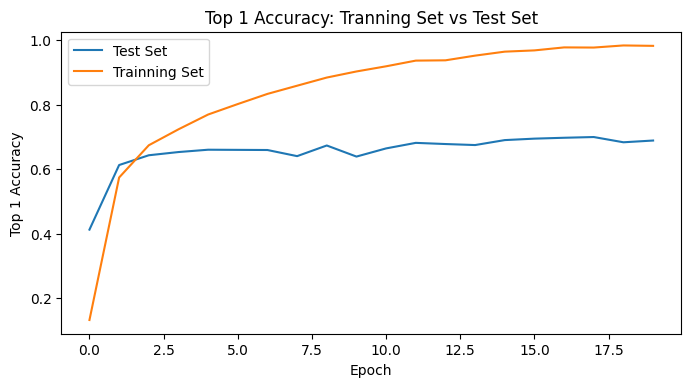

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 1 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 1 Accuracy")
plt.plot(history.history['val_categorical_accuracy'], label="Test Set")
plt.plot(history.history['categorical_accuracy'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + 'ServeNetTop1.pdf', format='pdf', dpi=300)

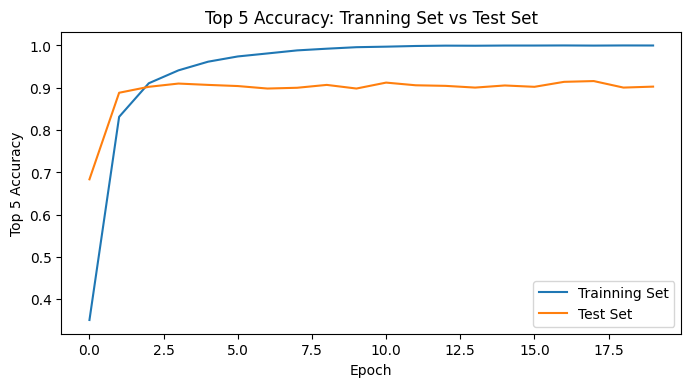

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot metrics
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Top 5 Accuracy: Tranning Set vs Test Set")
plt.xlabel("Epoch")
plt.ylabel("Top 5 Accuracy")
plt.plot(history.history['top_k_categorical_accuracy'], label="Trainning Set")
plt.plot(history.history['val_top_k_categorical_accuracy'], label="Test Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetTop5.pdf', format='pdf', dpi=300)

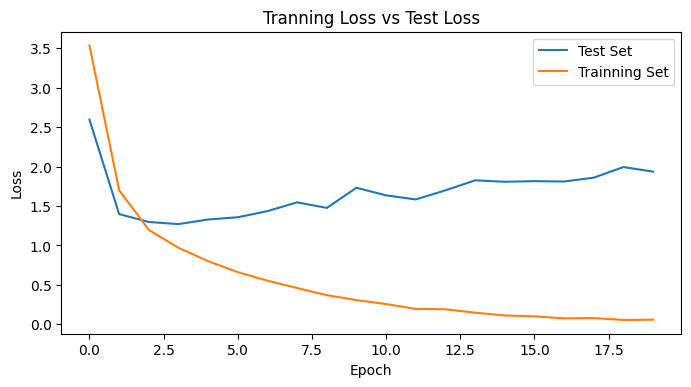

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)
plt.title("Tranning Loss vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['val_loss'], label="Test Set")
plt.plot(history.history['loss'], label="Trainning Set")
plt.legend()
plt.show()
plt.savefig(SavePrefix + '-ServeNetLoss.pdf', format='pdf', dpi=300)

In [ ]:
import pickle
  
f = open(SavePrefix + '-ServeNetHistory', 'wb')
pickle.dump(history.history, f)
f.close()

In [ ]:
import pickle

f = open(SavePrefix + '-ServeNetHistory', 'rb')
his = pickle.load(f)
f.close()

In [ ]:
val_top_k = his['val_top_k_categorical_accuracy']
print("top5: ", max(val_top_k))
print(np.argmax(val_top_k))
val_loss = his['val_loss']
print("loss: ", min(val_loss))
print(np.argmin(val_loss))
val_ca = his['val_categorical_accuracy']
print("top1: ", max(val_ca))
print(np.argmax(val_ca))

top5:  0.9158371090888977
17
loss:  1.270249605178833
3
top1:  0.699547529220581
17


# Restore Model

In [20]:
model.load_weights('Data/ServeNet-' + SavePrefix + '.hdf5')

In [ ]:
#model = load_model('Data/ServeNet-' + SavePrefix + '.hdf5', custom_objects={'WeightedLayer':WeightedLayer, 'KerasLayer':hub.KerasLayer})
# model = load_model('Data/ServeNet-' + SavePrefix + '.hdf5', compile=False, 
#                    custom_objects={'WeightedLayer':WeightedLayer, 'KerasLayer':hub.KerasLayer})

In [21]:
print("Training set:")
loss_train, top5error_train, top1error_train = model.evaluate(train_generator(), steps=tranning_steps_per_epoch)
print("Top5 Training accuracy = ", top5error_train)
print("Top1 Training accuracy = ", top1error_train)
print('Test set:')
loss_test, top5error_test, top1error_test = model.evaluate(test_generator(), steps=validation_steps)
print("Training accuracy = ", top5error_test)
print("Top1 Training accuracy = ", top1error_test)

Training set:
273/273 [==============================] - 49s 178ms/step - loss: 0.0251 - top_k_categorical_accuracy: 1.0000 - categorical_accuracy: 0.9919
Top5 Training accuracy =  1.0
Top1 Training accuracy =  0.9918699264526367
Test set:
70/70 [==============================] - 12s 174ms/step - loss: 1.8588 - top_k_categorical_accuracy: 0.9158 - categorical_accuracy: 0.6995
Training accuracy =  0.9158371090888977
Top1 Training accuracy =  0.699547529220581


# Compute accuracy on each category

In [33]:
# This code allows you to see the mislabelled examples
C = 50
# y_test_oh = np.eye(C)[Y_test.reshape(-1)]
# X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)

predY_test = []
Y_test = []

for d in testdata:
  predY_test.append(model.predict(d[0]))
  Y_test.append(d[1])

predY_test = np.concatenate(predY_test, axis=0)
Y_test = np.concatenate(Y_test, axis=0)

In [34]:
print(predY_test.shape)
print(Y_test.shape)

(2210, 50)
(2210, 50)


In [83]:
for i in range(200):
  p = np.argmax(predY_test[i])
  r = np.argmax(Y_test[i])
  if p != r:
    print(str(p) + "-" + str(r))

6-39
6-16
16-9
42-1
42-44
1-42
4-15
12-16
38-42
7-4
42-4
26-29
29-33
1-41
24-30
20-44
44-38
2-23
26-37
17-0
46-1
42-1
26-12
37-44
42-4
42-1
23-45
4-13
47-4
44-42
19-4
4-37
38-4
28-6
4-26
13-1
36-41
28-19
34-49
30-7
14-16
14-29
30-7
13-6
28-10
23-49
16-42
49-23
4-6
4-27
19-4
43-26
1-31
16-1
15-33
4-32
4-32
6-1
23-21
4-2
38-1
33-35
27-13


In [115]:
# Heatmap Data
non_onehot_pred_test_top1 = np.argmax(predY_test, axis=-1)
non_onehot_Y_test = np.argmax(Y_test, axis=-1)
categories = ['Advertising',
 'Analytics',
 'Application Development',
 'Backend',
 'Banking',
 'Bitcoin',
 'Chat',
 'Cloud',
 'Data',
 'Database',
 'Domains',
 'Education',
 'Email',
 'Enterprise',
 'Entertainment',
 'Events',
 'File Sharing',
 'Financial',
 'Games',
 'Government',
 'Images',
 'Internet of Things',
 'Mapping',
 'Media',
 'Medical',
 'Messaging',
 'Music',
 'News Services',
 'Marketing',
 'Other',
 'Payments',
 'Photos',
 'Project Management',
 'Real Estate',
 'Reference',
 'Science',
 'Search',
 'Security',
 'Shipping',
 'Social',
 'Sports',
 'Stocks',
 'Storage',
 'Telephony',
 'Tools',
 'Transportation',
 'Travel',
 'Video',
 'Weather',
 'eCommerce', 'All']

In [91]:
non_onehot_pred_test[2]

16.0

In [94]:
np.argmax(predY_test, axis=-1)[2]

6

In [96]:
predY_test[2]

array([1.9543766e-05, 1.2292243e-05, 4.0685163e-06, 1.6285935e-06,
       5.4160308e-04, 2.1859576e-06, 9.6751392e-01, 2.8486891e-06,
       1.1935567e-05, 8.0378399e-05, 3.3175736e-05, 3.8237110e-07,
       5.0976744e-04, 1.2080350e-02, 5.1562174e-04, 6.6604998e-06,
       1.1577218e-02, 3.6309979e-05, 1.1181695e-05, 2.0445625e-05,
       1.9724557e-06, 1.0122984e-03, 3.3494340e-05, 1.8072814e-04,
       1.7094630e-05, 9.0154856e-05, 5.7655267e-05, 5.1298535e-05,
       2.0461046e-06, 1.7399070e-07, 3.3211204e-06, 3.7844595e-06,
       3.6138389e-03, 5.3437350e-05, 1.5472331e-04, 1.4487941e-04,
       1.4189404e-05, 4.3974123e-06, 7.8334619e-05, 3.9626984e-04,
       1.3622931e-05, 4.1796517e-05, 3.5158606e-04, 1.9591427e-05,
       4.0805976e-06, 5.4858206e-04, 1.3083765e-05, 9.8741424e-05,
       9.0025251e-06, 4.4110584e-06], dtype=float32)

In [97]:
np.argmax(predY_test[2])

6

In [98]:
# If predict top5 includes true value, set true value to pred_test set
non_onehot_Y_test = np.argmax(Y_test, axis=-1)
non_onehot_pred_test = np.zeros((non_onehot_Y_test.shape))
non_onehot_pred_test_top5 = np.argsort(predY_test, axis=-1)[:, -5:][:, ::-1]

m = non_onehot_Y_test.shape[0]

for i in range(0, m):
    if non_onehot_Y_test[i] in non_onehot_pred_test_top5[i]:
        non_onehot_pred_test[i] = non_onehot_Y_test[i]


In [114]:
non_onehot_Y_test.shape

(2210,)

In [100]:
non_onehot_pred_test.shape

(2210,)

In [122]:
# This is Heat Map to compute TOP5, not real heat map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [123]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Advertising,Analytics,Application Development,Backend,Banking,Bitcoin,Chat,Cloud,Data,Database,Domains,Education,Email,Enterprise,Entertainment,Events,File Sharing,Financial,Games,Government,Images,Internet of Things,Mapping,Media,Medical,Messaging,Music,News Services,Marketing,Other,Payments,Photos,Project Management,Real Estate,Reference,Science,Search,Security,Shipping,Social,Sports,Stocks,Storage,Telephony,Tools,Transportation,Travel,Video,Weather,eCommerce,All
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Advertising,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49
Analytics,12,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32
Application Development,2,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
Backend,4,0,0,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27
Banking,19,0,0,0,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,154


In [124]:
cross.columns

Index(['Advertising', 'Analytics', 'Application Development', 'Backend',
       'Banking', 'Bitcoin', 'Chat', 'Cloud', 'Data', 'Database', 'Domains',
       'Education', 'Email', 'Enterprise', 'Entertainment', 'Events',
       'File Sharing', 'Financial', 'Games', 'Government', 'Images',
       'Internet of Things', 'Mapping', 'Media', 'Medical', 'Messaging',
       'Music', 'News Services', 'Marketing', 'Other', 'Payments', 'Photos',
       'Project Management', 'Real Estate', 'Reference', 'Science', 'Search',
       'Security', 'Shipping', 'Social', 'Sports', 'Stocks', 'Storage',
       'Telephony', 'Tools', 'Transportation', 'Travel', 'Video', 'Weather',
       'eCommerce', 'All'],
      dtype='object', name='Predicted')

In [125]:
all = cross["All"]

In [126]:
result = []

all = cross["All"]

for i in range(0, 50):
    acc = cross.iloc[i,i] / all[i]
    result.append(acc)

In [127]:
result

[1.0,
 0.625,
 0.9310344827586207,
 0.8518518518518519,
 0.8766233766233766,
 0.9629629629629629,
 0.8431372549019608,
 0.9,
 0.9090909090909091,
 0.9680851063829787,
 0.9642857142857143,
 0.9545454545454546,
 0.9803921568627451,
 0.9069767441860465,
 0.6428571428571429,
 0.9803921568627451,
 0.8627450980392157,
 0.9041095890410958,
 1.0,
 0.896551724137931,
 0.8823529411764706,
 0.927710843373494,
 0.9545454545454546,
 0.9416058394160584,
 0.9411764705882353,
 0.9333333333333333,
 1.0,
 0.9833333333333333,
 0.9545454545454546,
 0.8857142857142857,
 0.9514563106796117,
 0.9130434782608695,
 0.8260869565217391,
 0.9607843137254902,
 0.9782608695652174,
 0.8,
 0.7222222222222222,
 0.9411764705882353,
 0.8421052631578947,
 0.9666666666666667,
 1.0,
 0.95,
 0.9195402298850575,
 0.9487179487179487,
 0.8378378378378378,
 0.5517241379310345,
 0.975609756097561,
 0.7058823529411765,
 1.0,
 1.0]

In [67]:
np.std(result)

0.10002301366204598

In [68]:
acc_category = dict(zip(categories, result)) 

import json
with open('Data/ServeNet-' + SavePrefix + '_top5_acc_on_category.json', 'w') as fp:
    json.dump(acc_category, fp)

fp.close()

In [69]:
acc_category

{'Advertising': 1.0,
 'Analytics': 0.625,
 'Application Development': 0.9310344827586207,
 'Backend': 0.8518518518518519,
 'Banking': 0.8766233766233766,
 'Bitcoin': 0.9629629629629629,
 'Chat': 0.8431372549019608,
 'Cloud': 0.9,
 'Data': 0.9090909090909091,
 'Database': 0.9680851063829787,
 'Domains': 0.9642857142857143,
 'Education': 0.9545454545454546,
 'Email': 0.9803921568627451,
 'Enterprise': 0.9069767441860465,
 'Entertainment': 0.6428571428571429,
 'Events': 0.9803921568627451,
 'File Sharing': 0.8627450980392157,
 'Financial': 0.9041095890410958,
 'Games': 1.0,
 'Government': 0.896551724137931,
 'Images': 0.8823529411764706,
 'Internet of Things': 0.927710843373494,
 'Mapping': 0.9545454545454546,
 'Marketing': 0.9545454545454546,
 'Media': 0.9416058394160584,
 'Medical': 0.9411764705882353,
 'Messaging': 0.9333333333333333,
 'Music': 1.0,
 'News Services': 0.9833333333333333,
 'Other': 0.8857142857142857,
 'Payments': 0.9514563106796117,
 'Photos': 0.9130434782608695,
 'Proj

# Top1 HeatMap

In [128]:
# Heat Map

# cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test.reshape(len(non_onehot_pred_test),), rownames=['Actual'], colnames=['Predicted'], margins=True)
cross = pd.crosstab(non_onehot_Y_test, non_onehot_pred_test_top1, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [129]:
cross.index = categories
cross.index.name = "Actual"
cross.columns = categories
cross.columns.name = "Predicted"
cross.head()

Predicted,Advertising,Analytics,Application Development,Backend,Banking,Bitcoin,Chat,Cloud,Data,Database,Domains,Education,Email,Enterprise,Entertainment,Events,File Sharing,Financial,Games,Government,Images,Internet of Things,Mapping,Media,Medical,Messaging,Music,News Services,Marketing,Other,Payments,Photos,Project Management,Real Estate,Reference,Science,Search,Security,Shipping,Social,Sports,Stocks,Storage,Telephony,Tools,Transportation,Travel,Video,Weather,eCommerce,All
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Advertising,42,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,49
Analytics,0,1,0,0,5,0,3,0,0,0,0,1,0,2,1,0,1,2,0,0,0,2,0,0,0,0,1,2,0,0,0,2,0,0,0,0,0,0,2,0,0,0,4,0,0,0,1,2,0,0,32
Application Development,0,0,24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
Backend,0,1,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,3,0,0,0,1,0,2,0,0,0,0,0,2,1,0,0,0,0,0,0,0,27
Banking,0,5,0,1,79,1,6,6,1,0,0,0,1,1,2,0,4,3,0,6,3,5,0,0,0,1,0,2,0,1,1,1,2,3,1,0,0,1,1,1,2,0,9,0,2,0,0,2,0,0,154


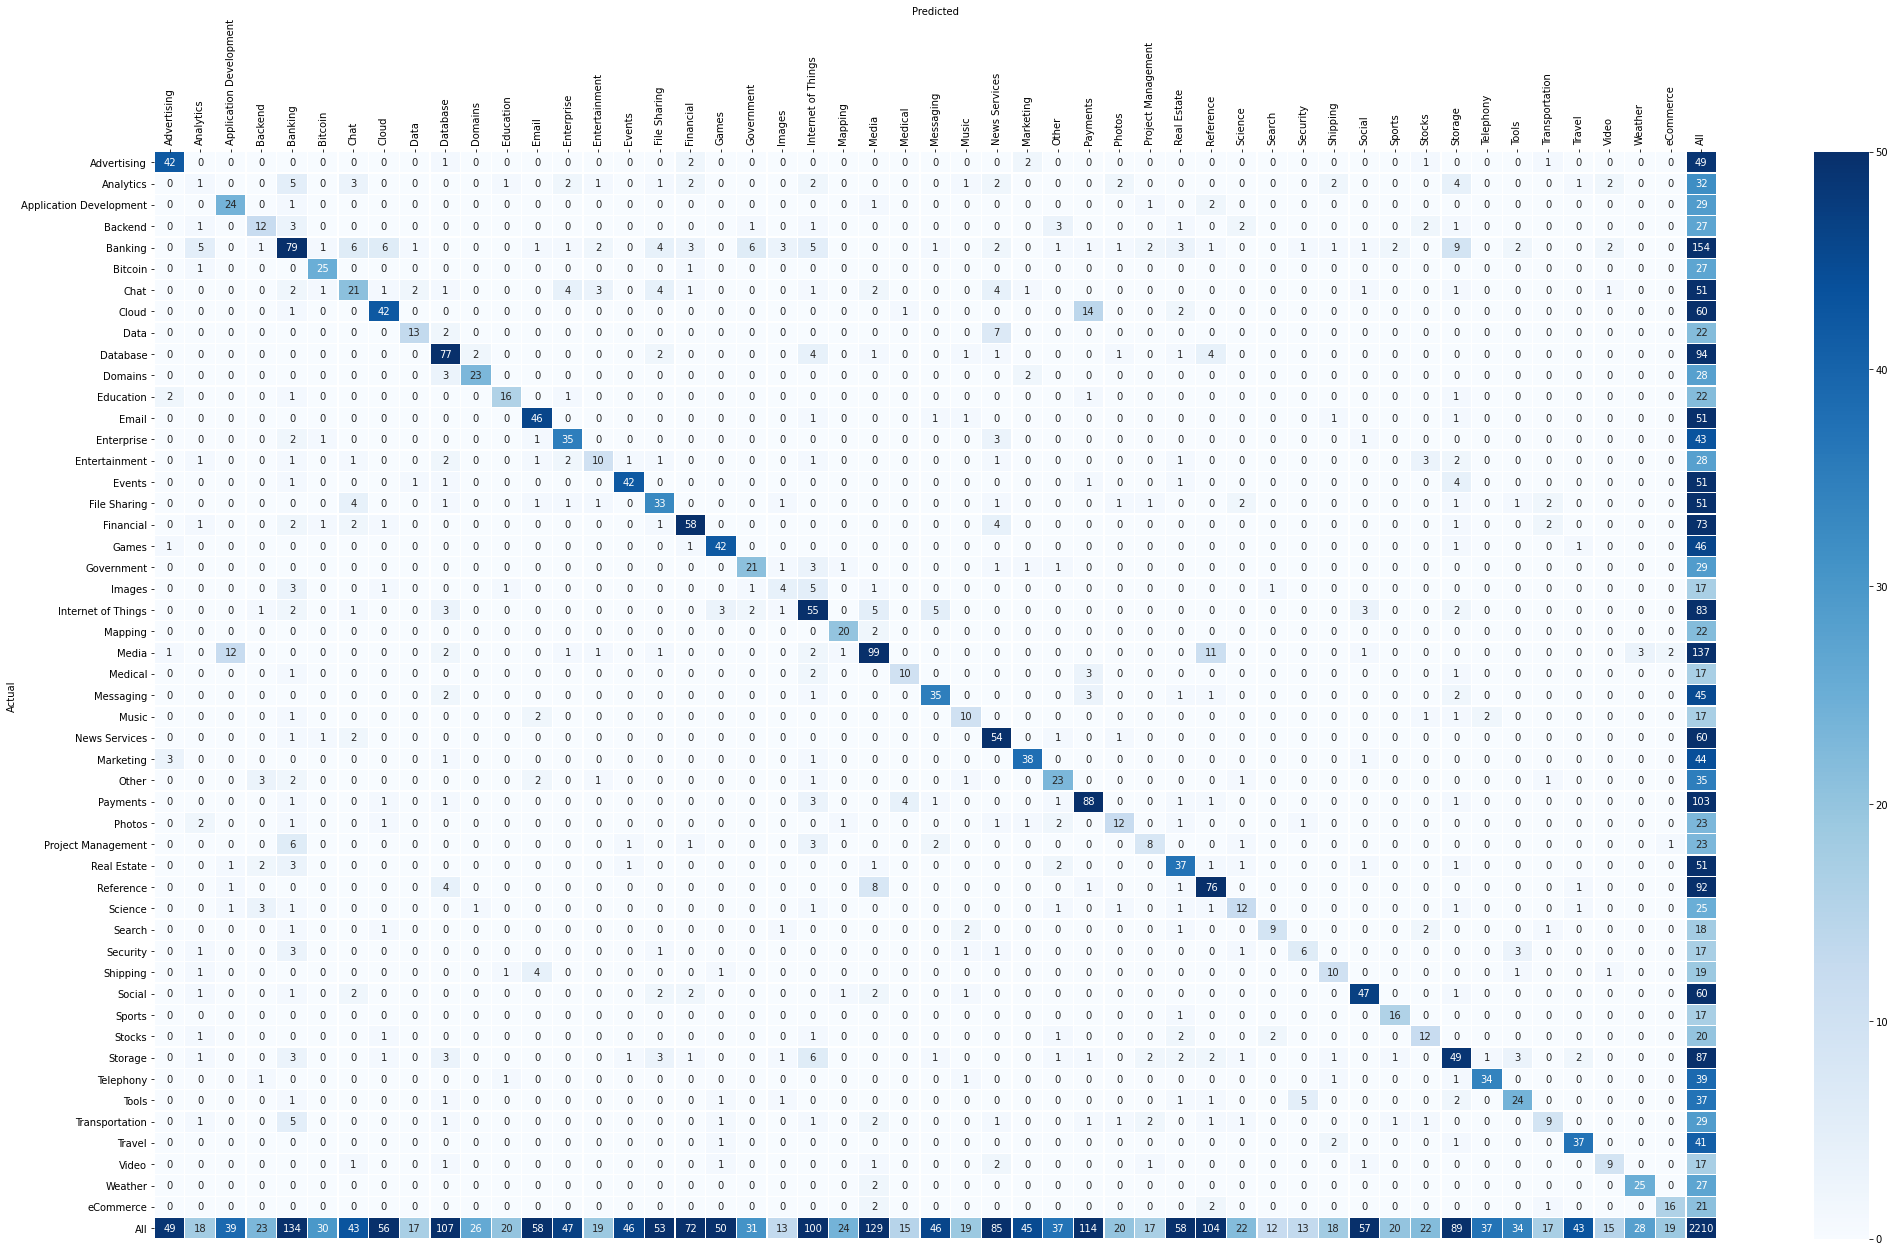

In [130]:
f, ax = plt.subplots(figsize=(35,20))

sns.heatmap(cross, annot=True, vmin=0, fmt="d", vmax=50, ax=ax, linewidths=.3, cmap=plt.cm.Blues)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


plt.yticks(rotation=0) 
plt.xticks(rotation=90) 

plt.savefig('Data/ServeNet-' + SavePrefix + 'Top5-ServenetNewHeatMap.pdf', format='pdf', dpi=300)